In [87]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
import scipy.integrate as integrate
from __future__ import unicode_literals
from sklearn import preprocessing as prep
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.mixture import GaussianMixture as gm
from multiprocessing import Pool
from sklearn.cluster import KMeans
from sklearn.mixture import BayesianGaussianMixture as bgm

In [278]:
class LOB:
    def __init__(self, wiersz):
        self.zmiana = 0
        self.dzien = int(wiersz[0]) % 100
        self.czas = int(wiersz[1])
        i = 3
        while (wiersz[i] != 'ASK'):
            i += 1
        bid = wiersz[3:i]
        ask = wiersz[(i+1):]
        self.bid = np.zeros((int((len(bid) / 2)), 2))
        self.ask = np.zeros((int((len(ask) / 2)), 2))
        for i in range(0, len(bid), 2):
            self.bid[int(i / 2)][0] = float(bid[i]) 
            self.bid[int(i / 2)][1] = float(bid[i+1])
        for i in range(0, len(ask), 2):
            self.ask[int(i / 2)] = [float(ask[i]), float(ask[i+1])]
        self.midPrice = (self.bid[len(self.bid) - 1][0] + self.ask[0][0]) / 2
    def __str__(self):
        return "Dzień: " + self.dzien + ", Czas: " + self.czas + ", midPrice: " + str(self.midPrice)

def generujZmiane(X):
    for i in range(len(X) - 1):
        if (X[i].midPrice < X[i + 1].midPrice):
            X[i].zmiana = 1
        if (X[i].midPrice > X[i + 1].midPrice):
            X[i].zmiana = -1
        if (X[i].midPrice == X[i + 1].midPrice):
            X[i].zmiana = 0
    return np.array([i.zmiana for i in X])

def czas(h, m):
    mnoznikM = 100000
    mnoznikH = 10000000
    return h*mnoznikH + m*mnoznikM

def czasOdwrotny(x):
    mnoznikM = 100000
    mnoznikH = 10000000
    return (int(x / mnoznikH), int((x % mnoznikH) / mnoznikM))

def generujPozycje(x, odSrodka):
    if odSrodka:
        pozMidPrice = (x.midPrice - minimum) * 10
        pozMidPriceInt = int(np.floor(pozMidPrice))
        pozLewa = pozMidPriceInt
        pozPrawa = pozMidPriceInt + 1
        if (pozMidPrice - pozMidPriceInt < 0.0001):
            pozLewa -= 1
        return (pozLewa, pozPrawa)
    else:
        pozLewa = (x.bid[-1][0] - minimum ) * 10
        pozPrawa = (x.ask[0][0] - minimum ) * 10
        pozLewaInt = int(np.round(pozLewa))
        pozPrawaInt = int(np.round(pozPrawa))
        return (pozLewaInt, pozPrawaInt)
    
def generujPrzedzialy(x, ilosc, f, odSrodka):
    pozLewa, pozPrawa = generujPozycje(x, odSrodka)
    przedzialy = []
    wspXowe = []
    for i in range(ilosc):
        fi = f(i)
        wspXowe.append((pozPrawa / 10) + minimum + (fi / 2))
        wspXowe.append((pozLewa / 10) + minimum - (fi / 2))
        fi10 = int(np.floor(fi*10))
        tmpList = np.arange(fi10)
        przedzialy.append(pozPrawa + tmpList)
        pozPrawa += fi10
        pozLewa -= fi10
        przedzialy.append(pozLewa + 1 + tmpList)
    return przedzialy, wspXowe
        
def generujTabliceTickow(tablica, X, ilosc, f, odSrodka):
    wynik = np.zeros((len(X), 2 * ilosc))
    listaWspXowych = []
    for i in range(len(X)):
        wiersz = tablica[i]
        przedzialy, wspXowe = generujPrzedzialy(X[i], ilosc, f, odSrodka)
        listaWspXowych.append(wspXowe)
        for j in range(2 * ilosc):
            przedzial = przedzialy[j]
            przedzial = przedzial[przedzial >= 0]
            przedzial = przedzial[przedzial < liczbaWspolrzednych]
            wynik[i][j] = np.sum(wiersz[przedzial])
    return wynik, listaWspXowych

def narysujPrzykladowyWykres(xAsk, yAsk, xBid, yBid, midPrice, nawa, zblizone = False):
    plt.rcParams = plt.rcParamsDefault
    plt.close()
    plt.rc('font', family='Arial')
    fig = plt.figure(figsize=(9, 3))
    
    maks = np.max([np.max(yBid), np.max(yAsk)])
    plt.xlabel('Cena')
    plt.ylabel("Ilość")
    szerokosc = 0.2
    if (zblizone):
        lewe = midPrice - 8
        prawe = midPrice + 8
        maks = np.max([np.max(yBid[xBid >= lewe]), np.max(yAsk[xAsk <= prawe])])
        plt.xticks(np.arange(lewe, prawe + 2, 2))
        plt.axis([lewe, prawe, 0, maks])
        szerokosc /= 10
    else:
        plt.xticks(np.arange(midPrice-75, midPrice+125, 25))
        plt.axis([midPrice-75, midPrice+100, 0, maks])
    plt.title("Ilość akcji w stosunku do ceny")
    plt.bar(xBid, yBid, width=szerokosc, color = 'blue', edgecolor = "blue", label = "BID")
    plt.bar(xAsk, yAsk, width=szerokosc, color = 'red', edgecolor = "red", label = "ASK")
    
    plt.bar(midPrice, maks, width=szerokosc, color = 'green', edgecolor = "green", label = "mid-price")

    plt.legend()
    plt.tight_layout()

    plt.savefig(nawa)
    plt.show()
    plt.close()

def generujImbalance(X):
    i = 0
    Imbalance = np.zeros((X.shape[0], 1))
    for wiersz in X: 
        bid = wiersz.bid[-1, 1]
        ask = wiersz.ask[0, 1]
        Imbalance[i] = (bid - ask) / (bid + ask)
        i += 1
    return Imbalance

In [3]:
daneS = 'OrderBookSnapshots.csv';
with open(daneS, 'r') as f:
    dane = f.readlines()
X = []
for wiersz in dane:
    newWiersz = wiersz.split()
    X.append(LOB(newWiersz))
X = np.array(X)
zmiana = generujZmiane(X)

In [4]:
print ("Ilość danych:", len(X))

Ilość danych: 5474


In [5]:
iloscBlednychDanych = np.sum(np.array([(wiersz.bid[-1][0] > wiersz.ask[0][0]) for wiersz in X]))
print("ilość błędnych danych:", iloscBlednychDanych)

ilość błędnych danych: 150


In [6]:
print("dzień    ilość danych")
for k in range(0, 17):
    maska = np.array([(wiersz.dzien == k) for wiersz in X])
    ilosc = np.sum(maska)
    print(k, "      ", ilosc)

dzień    ilość danych
0        0
1        1
2        545
3        547
4        545
5        550
6        549
7        0
8        0
9        548
10        549
11        546
12        548
13        546
14        0
15        0
16        0


In [7]:
listaDni = np.array([2, 3, 4, 5, 6, 9, 10, 11, 12 ,13])

In [8]:
procenty = np.zeros((14, 24))
maska
for k in listaDni:
    maska = np.array([(wiersz.dzien == k) for wiersz in X])
    ilosc = np.max([np.sum(maska), 1])
    for i in range(24):
        procenty[k-1][i] = (np.sum([(wiersz.czas >= czas(i, 0) and wiersz.czas < czas(i+1,0)) for wiersz in X[maska]]) / ilosc * 100)
        
wiersz = ''
wynikProcentow = np.sum(procenty[(listaDni-1)], axis = 0) / 10
for i in range(6, 20):
    print('{0}-{1}:  {2:.2f}%  '.format(i, i+1, wynikProcentow[i]))

6-7:  0.00%  
7-8:  1.64%  
8-9:  10.96%  
9-10:  10.96%  
10-11:  10.96%  
11-12:  10.96%  
12-13:  10.96%  
13-14:  10.96%  
14-15:  10.96%  
15-16:  10.96%  
16-17:  9.88%  
17-18:  0.58%  
18-19:  0.16%  
19-20:  0.00%  


In [9]:
maskaCzasu = np.array([wiersz.czas > czas(8, 0) and wiersz.czas < czas(16, 45) for wiersz in X])
listaGdzieBylyZmiany = np.arange(len(X))[np.array([(i.zmiana != 0) for i in X])]
indeksy = []
for indeks in listaGdzieBylyZmiany:
    if (maskaCzasu[indeks]):
        indeksy.append(indeks)
indeksy = np.array(indeksy)

In [10]:
iloscBlednychDanych = np.sum(np.array([(wiersz.bid[-1][0] > wiersz.ask[0][0]) for wiersz in X[maskaCzasu]]))
print("ilość błędnych danych:", iloscBlednychDanych)

ilość błędnych danych: 50


In [11]:
maskaCzasu = np.array([wiersz.czas > czas(8, 0) and wiersz.czas < czas(16, 30) for wiersz in X])
listaGdzieBylyZmiany = np.arange(len(X))[np.array([(i.zmiana != 0) for i in X])]
indeksy = []
for indeks in listaGdzieBylyZmiany:
    if (maskaCzasu[indeks]):
        indeksy.append(indeks)
indeksy = np.array(indeksy)

In [12]:
iloscBlednychDanych = np.sum(np.array([(wiersz.bid[-1][0] > wiersz.ask[0][0]) for wiersz in X[maskaCzasu]]))
print("ilość błędnych danych:", iloscBlednychDanych)

ilość błędnych danych: 0


In [13]:
print("Procent danych ograniczonych do przedziału od 8:00 do 16:30: {0:.2f}%".format(100*np.sum(maskaCzasu) / len(X)))

Procent danych ograniczonych do przedziału od 8:00 do 16:30: 92.99%


In [14]:
print("Pozbyliśmy się: {0} danych".format(len(X) - np.sum(maskaCzasu)))

Pozbyliśmy się: 384 danych


In [15]:
print("Ilość l(t), w których z(t) != 0: {0}".format(len(listaGdzieBylyZmiany)))
print("Procent l(t), w których z(t) != 0: {0:.2f}%".format(100*len(listaGdzieBylyZmiany) / len(X)))

Ilość l(t), w których z(t) != 0: 4652
Procent l(t), w których z(t) != 0: 84.98%


In [16]:
print("Ilość l(t), w których z(t) != 0: {0}".format(len(indeksy)))
print("Procent l(t) ograniczonych do przedziału czasowego, w których z(t) != 0: {0:.2f}%".format(100*len(indeksy) / len(X)))

Ilość l(t), w których z(t) != 0: 4588
Procent l(t) ograniczonych do przedziału czasowego, w których z(t) != 0: 83.81%


In [17]:
print("Procent l(t), w których z(t) != 0 ograniczonych do przedziału czasowego w porównaniu do tych nie ograniczonych: {0:.2f}%".format(100*len(indeksy) / len(listaGdzieBylyZmiany)))

Procent l(t), w których z(t) != 0 ograniczonych do przedziału czasowego w porównaniu do tych nie ograniczonych: 98.62%


In [18]:
X = X[indeksy]

In [19]:
print("Ilość danych po redukcjach:", len(X))

Ilość danych po redukcjach: 4588


In [20]:
zmiana = generujZmiane(X)

In [21]:
print("Ilość danych, w których z(t) = 1: {0}".format(np.sum(zmiana == 1)) )
print("procent l(t), w których z(t) = 1: {0:.2f}%".format(100*np.sum(zmiana == 1) / len(X)) )

Ilość danych, w których z(t) = 1: 2292
procent l(t), w których z(t) = 1: 49.96%


In [22]:
print("Ilość danych, w których z(t) = -1: {0}".format(np.sum(zmiana == -1)) )
print("procent l(t), w których z(t) = -1: {0:.2f}%".format(100*np.sum(zmiana == -1) / len(X)) )

Ilość danych, w których z(t) = -1: 2296
procent l(t), w których z(t) = -1: 50.04%


In [23]:
minimum = 100000
maksimum = 0
for wiersz in X:
    bid = wiersz.bid[0, 0]
    ask = wiersz.ask[-1, 0]
    if(ask > maksimum):
        maksimum = ask
    if(bid < minimum):
        minimum = bid 
liczbaWspolrzednych = int((maksimum - minimum) * 10 + 1)

In [135]:
np.save("minimum.npy", minimum)
np.save("maksimum.npy", maksimum)

In [24]:
print("minimum: {0}, maksimum: {1}".format(minimum, maksimum))

minimum: 494.0, maksimum: 900.0


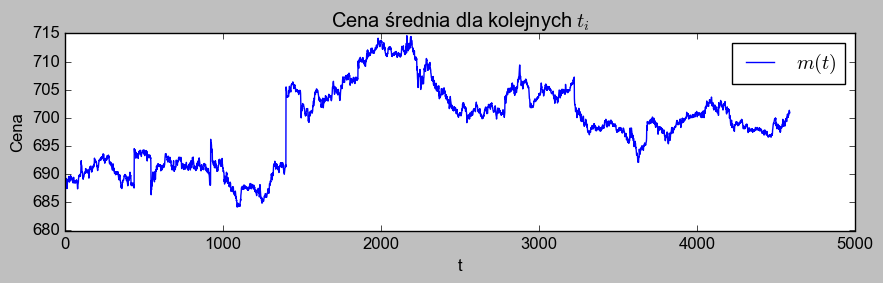

In [279]:
plt.rc('font', family='Arial')
plt.rcParams["figure.figsize"] = [9, 3]
plt.title("Cena średnia dla kolejnych $t_i$")
plt.xlabel('t')
plt.ylabel("Cena")
kolejneCzasy = np.arange(len(X))
kolejneMidPrice = np.array([wiersz.midPrice for wiersz in X])
plt.plot(kolejneCzasy, kolejneMidPrice, label = "$m(t)$")
plt.legend()
plt.tight_layout()
plt.savefig("CenaKolejnychMidPrice")
plt.show()
plt.close()

In [26]:
nrWiersza = 2300
midPrice = X[nrWiersza].midPrice

In [27]:
tablica = np.zeros((len(X), liczbaWspolrzednych), dtype=int)
i = 0
for wiersz in X:
    for item in wiersz.bid:
        tablica[i][int(np.round((item[0] - minimum)*10))] = int(np.round(-item[1]))
    for item in wiersz.ask:
        tablica[i][int(np.round((item[0] - minimum)*10))] = int(np.round(item[1]))
    i += 1

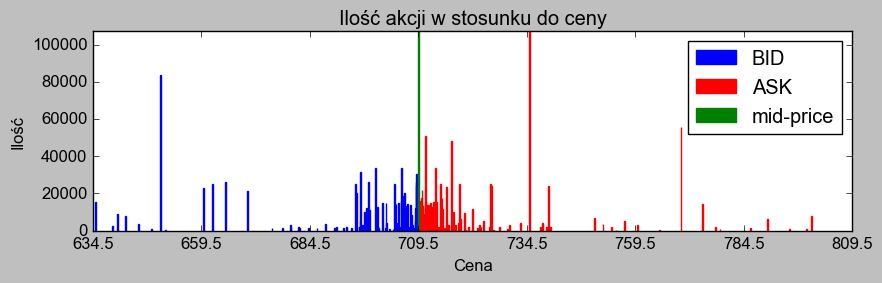

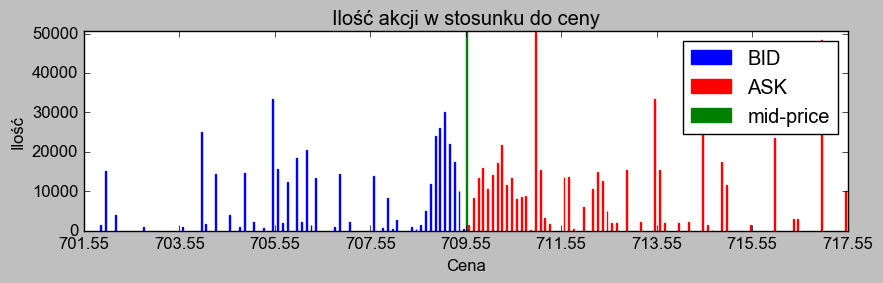

In [280]:
wiersz = X[nrWiersza]
narysujPrzykladowyWykres(wiersz.ask[:, 0], wiersz.ask[:, 1], wiersz.bid[:, 0], wiersz.bid[:, 1],
                         midPrice, "PrzykladDanychDlaListyLobow")
narysujPrzykladowyWykres(wiersz.ask[:, 0], wiersz.ask[:, 1], wiersz.bid[:, 0], wiersz.bid[:, 1],
                         midPrice, "PrzykladDanychDlaListyLobowPrzyblizony", True)

In [29]:
def fPierw(x):
    return (((0.1 + (0.05 + x / 20) * np.sqrt(x)) * 10) / 10)

def fLo(x):
    return .1 if (x < 1) else (np.log2(x + 1))/10

def f1(x):
    return 1

In [30]:
np.sum([(np.floor(fPierw(i)*10))/10 for i in range(30)])

101.49999999999999

In [31]:
np.sum([(np.floor(fLo(i)*10))/10 for i in range(180)])

101.40000000000002

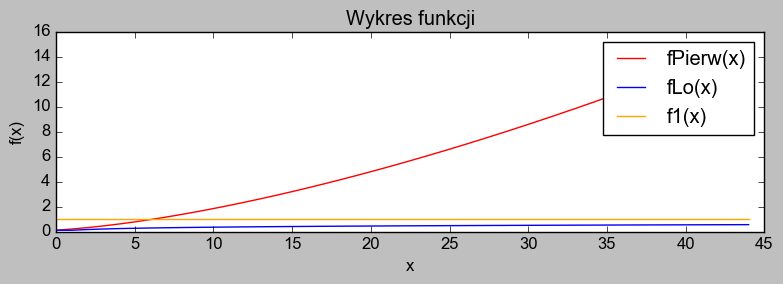

In [281]:
plt.rcParams["figure.figsize"] = [8, 3]
dl = 45
plt.plot(np.arange(dl), [fPierw(i) for i in range(dl)], color = "red", label = "fPierw(x)")
plt.plot(np.arange(dl), [fLo(i) for i in range(dl)], color = "blue", label = "fLo(x)")
plt.plot(np.arange(dl), [f1(i) for i in range(dl)], color='orange', label = "f1(x)")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Wykres funkcji")

plt.legend()

plt.tight_layout()
plt.savefig("wykresFunkcji")
plt.show()

In [33]:
ticki_BA_fPierw, ticki_BA_fPierw_Wsp = generujTabliceTickow(tablica, X, 30, fPierw, False)
ticki_M_fPierw, ticki_M_fPierw_Wsp = generujTabliceTickow(tablica, X, 30, fPierw, True)

In [34]:
ticki_BA_fLo, ticki_BA_fLo_Wsp = generujTabliceTickow(tablica, X, 180, fLo, False)
ticki_M_fLo, ticki_M_fLo_Wsp = generujTabliceTickow(tablica, X, 180, fLo, True)

In [35]:
ticki_BA_f1, ticki_BA_f1_Wsp = generujTabliceTickow(tablica, X, 100, f1, False)
ticki_M_f1, ticki_M_f1_Wsp = generujTabliceTickow(tablica, X, 100, f1, True)

In [36]:
np.save("ticki_BA_fPierw.npy", ticki_BA_fPierw)
np.save("ticki_M_fPierw.npy", ticki_M_fPierw)
np.save("ticki_BA_fLo.npy", ticki_BA_fLo)
np.save("ticki_M_fLo.npy", ticki_M_fLo)
np.save("ticki_BA_f1.npy", ticki_BA_f1)
np.save("ticki_M_f1.npy", ticki_M_f1)

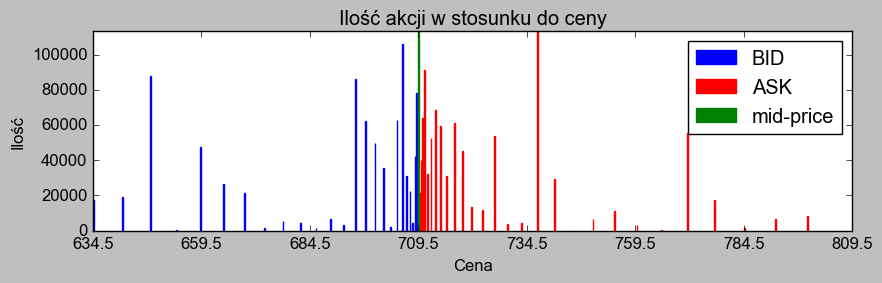

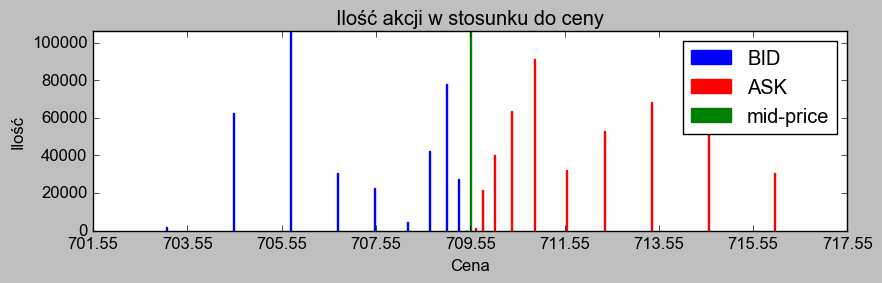

In [282]:
wiersz = ticki_M_fPierw[nrWiersza]
wierszWsp = np.array(ticki_M_fPierw_Wsp[nrWiersza])
askMask = np.arange(0, len(wiersz), 2)
bidMask = askMask + 1
narysujPrzykladowyWykres(wierszWsp[askMask], wiersz[askMask],
                         wierszWsp[bidMask], wiersz[bidMask] * (-1),
                         midPrice, "ticki_M_fPierwPrzyklad")

narysujPrzykladowyWykres(wierszWsp[askMask], wiersz[askMask],
                         wierszWsp[bidMask], wiersz[bidMask] * (-1),
                         midPrice, "ticki_M_fPierwPrzykladPrzyblizony", zblizone = True)

In [49]:
forMM = []
for i in range(X.size):
    oneLine = []
    for ask in X[i].ask:
        oneLine.extend([ask[0] for j in range(int(np.round(ask[1]/100)))])
    for bid in X[i].bid:
        oneLine.extend([bid[0] for j in range(int(np.round(bid[1]/100)))])
    forMM.append(oneLine)

5


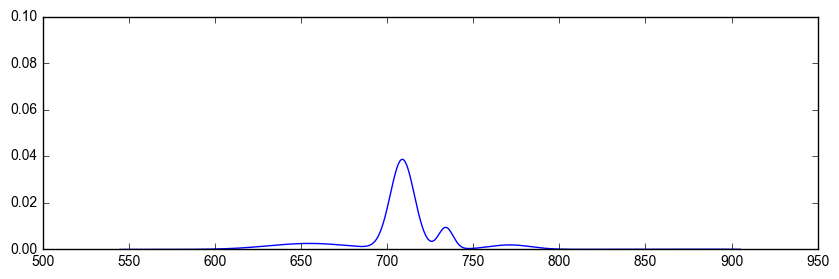

10


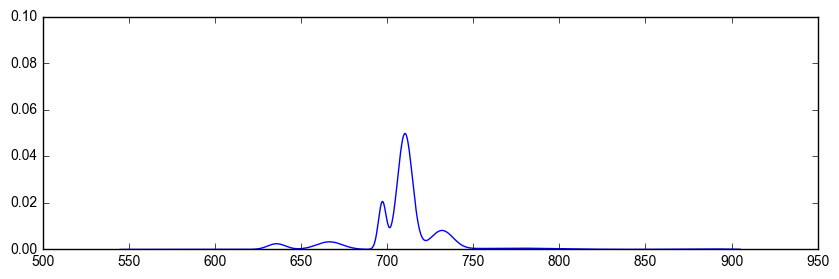

15


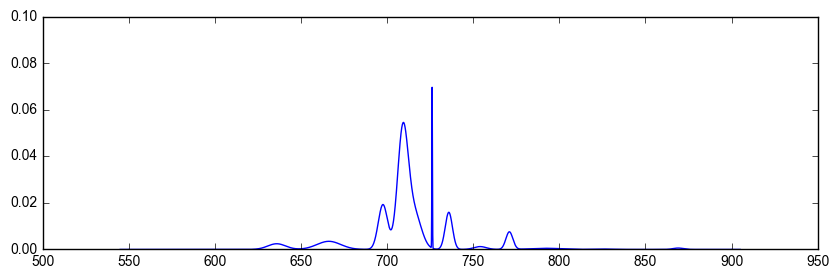

20


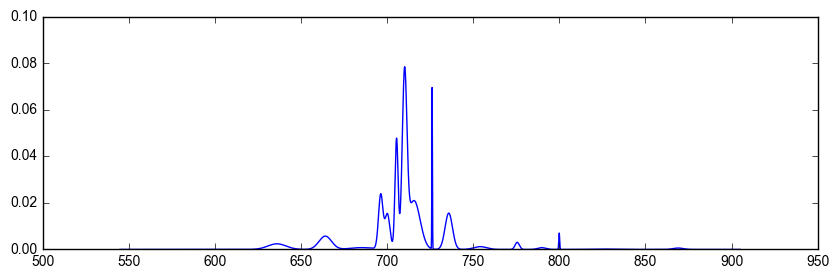

25


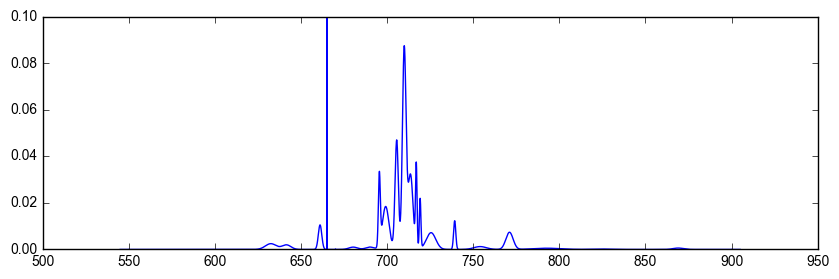

30


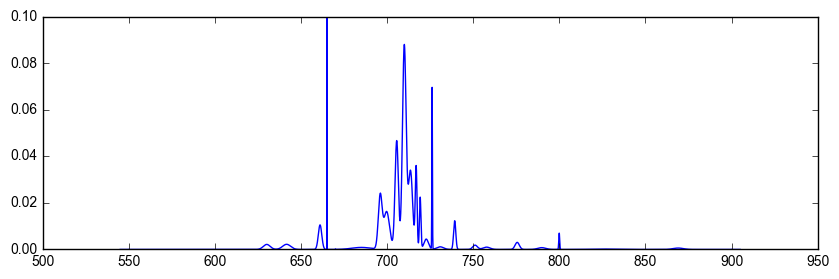

35


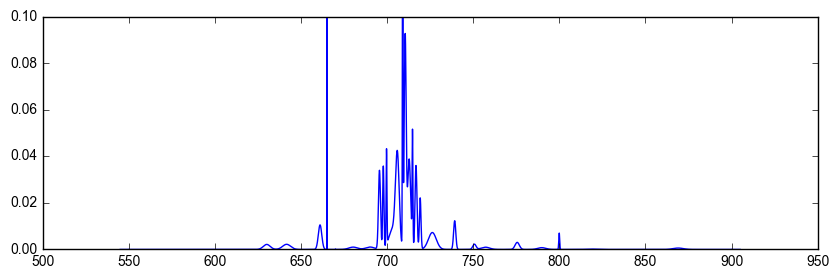

40


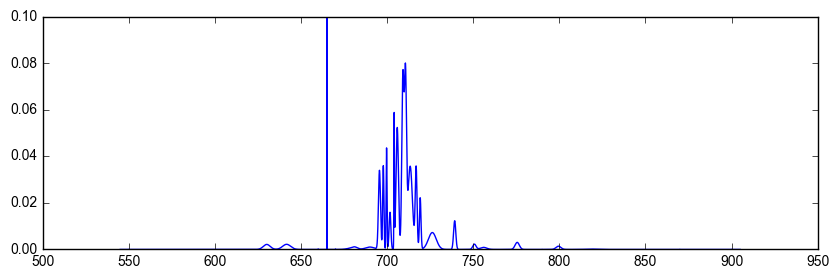

50


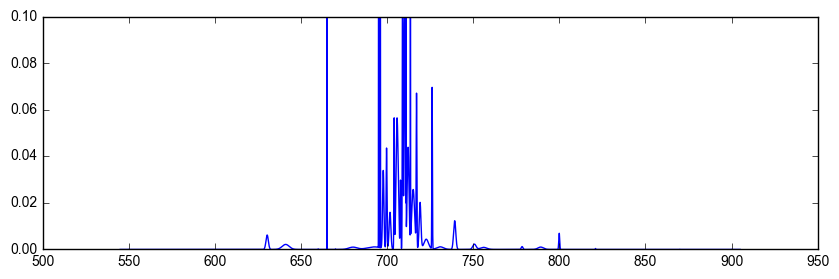

60


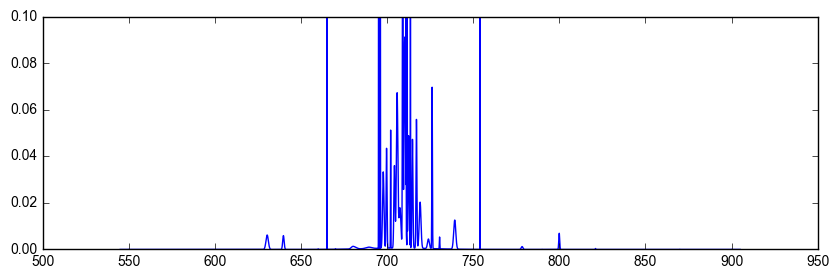

70


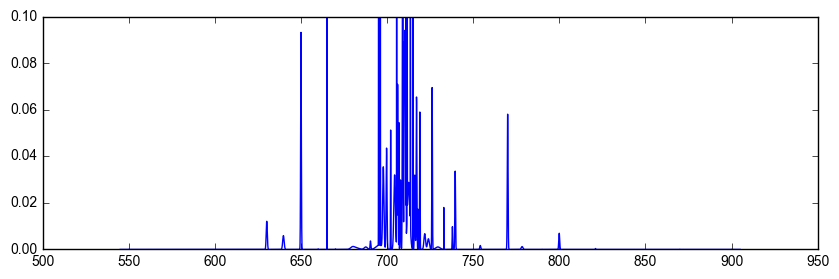

80


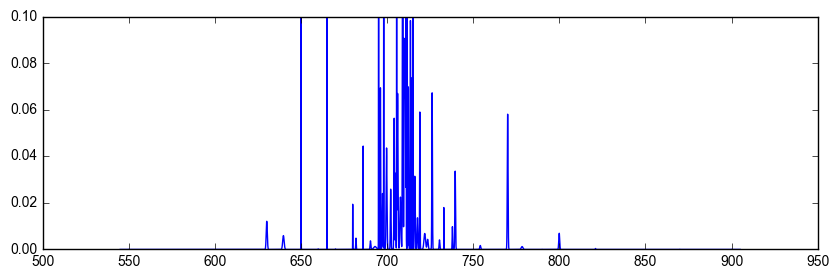

In [131]:
for k in [5, 10, 15, 20, 25, 30, 35, 40, 50, 60, 70, 80]:
    gmmList = []
    for oneLine in forMM:
        gmm = gm(n_components=k, n_init=2, random_state = 1)
        gmm.fit(X=np.expand_dims(oneLine, 1))
        gmmList.append(gmm)
        
    plt.rcParams["figure.figsize"] = [10, 3]
    minimalne = X[nrWiersza].bid[0][0]-5
    maksymalne = X[nrWiersza].ask[-1][0]+5
    gmm_x = np.linspace(minimalne, maksymalne, 10000)
    gmm_y = np.exp(gmmList[nrWiersza].score_samples(gmm_x.reshape(-1, 1)))
    plt.ylim(0, 0.1)
    plt.plot(gmm_x, gmm_y)
    print(k)
    plt.show()
    np.save("gmmList" + str(k) + ".npy", gmmList)

In [133]:
np.save("X.npy", X)

In [287]:
X[nrWiersza].ask[-1][0]+5

905.0

In [303]:
gmm10przyklad = np.load("gmmList10.npy")[nrWiersza]
gmm35przyklad = np.load("gmmList35.npy")[nrWiersza]
gmm70przyklad = np.load("gmmList70.npy")[nrWiersza]

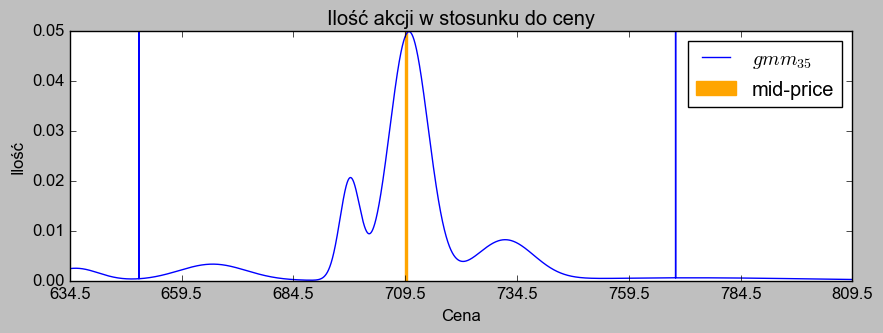

In [350]:
plt.rcParams = plt.rcParamsDefault
plt.close()
plt.rc('font', family='Arial')
fig = plt.figure(figsize=(9, 3))
plt.xlabel('Cena')
plt.ylabel("Ilość")
lewe = midPrice - 75
prawe = midPrice + 100
plt.xticks(np.arange(lewe, prawe + 25, 25))
plt.axis([lewe, prawe, 0, 0.05])

gmm_x = np.linspace(lewe, prawe + 25, 1000000)
gmm10_y = np.exp(gmm10przyklad.score_samples(gmm_x.reshape(-1, 1)))
plt.plot(gmm_x, gmm10_y, color = 'blue',  label = '$gmm_{35}$')
plt.title("Ilość akcji w stosunku do ceny")
plt.bar(midPrice, 0.1, width = 0.3, color = 'orange', edgecolor = "orange", label = "mid-price")
plt.legend()
plt.tight_layout()
plt.savefig("przykladDanychDlaGmm10.png")
plt.show()
plt.close()

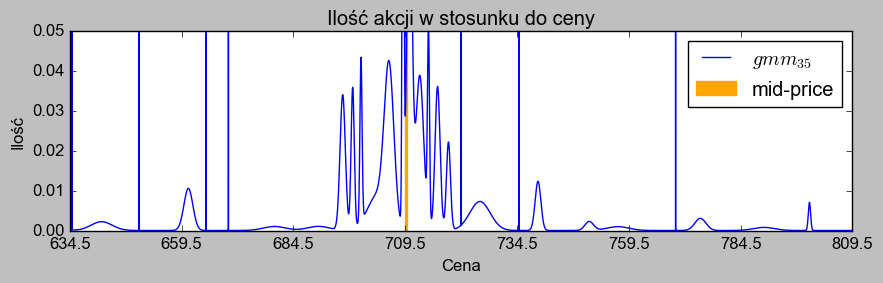

In [348]:
plt.rcParams = plt.rcParamsDefault
plt.close()
plt.rc('font', family='Arial')
fig = plt.figure(figsize=(9, 3))
plt.xlabel('Cena')
plt.ylabel("Ilość")
lewe = midPrice - 75
prawe = midPrice + 100
plt.xticks(np.arange(lewe, prawe + 25, 25))
plt.axis([lewe, prawe, 0, 0.05])

gmm_x = np.linspace(lewe, prawe + 25, 1000000)
gmm35_y = np.exp(gmm35przyklad.score_samples(gmm_x.reshape(-1, 1)))
plt.plot(gmm_x, gmm35_y, color = 'blue',  label = '$gmm_{35}$')
plt.title("Ilość akcji w stosunku do ceny")
plt.bar(midPrice, 0.1, width = 0.3, color = 'orange', edgecolor = "orange", label = "mid-price")
plt.legend()
plt.tight_layout()
plt.savefig("przykladDanychDlaGmm35.png")
plt.show()
plt.close()

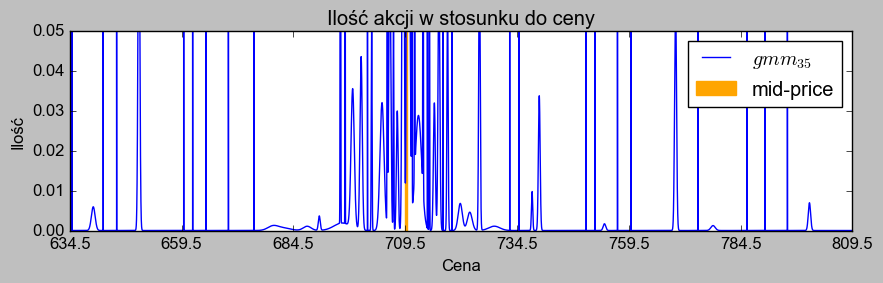

In [347]:
plt.rcParams = plt.rcParamsDefault
plt.close()
plt.rc('font', family='Arial')
fig = plt.figure(figsize=(9, 3))
plt.xlabel('Cena')
plt.ylabel("Ilość")
lewe = midPrice - 75
prawe = midPrice + 100
plt.xticks(np.arange(lewe, prawe + 25, 25))
plt.axis([lewe, prawe, 0, 0.05])

gmm_x = np.linspace(lewe, prawe + 25, 1000000)
gmm70_y = np.exp(gmm70przyklad.score_samples(gmm_x.reshape(-1, 1)))
plt.plot(gmm_x, gmm70_y, color = 'blue',  label = '$gmm_{35}$')
plt.title("Ilość akcji w stosunku do ceny")
plt.bar(midPrice, 0.1, width = 0.4, color = 'orange', edgecolor = "orange", label = "mid-price")
plt.legend()
plt.tight_layout()
plt.savefig("przykladDanychDlaGmm70.png")
plt.show()
plt.close()

C:\Program Files\Anaconda3\lib\site-packages\sklearn\mixture\base.py:237: ConvergenceWarning: Initialization 10 did not converged. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


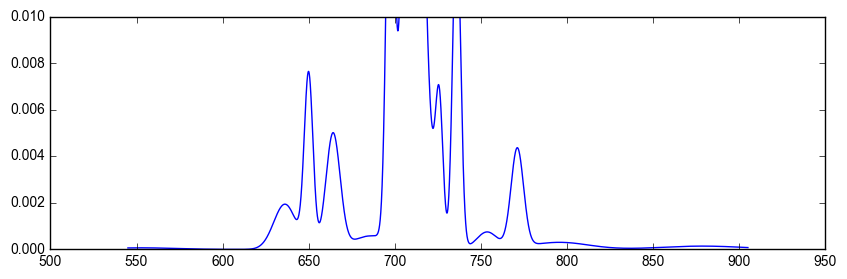

In [125]:
plt.rcParams = plt.rcParamsDefault
plt.close()
plt.rc('font', family='Arial')
fig = plt.figure(figsize=(9, 3))

maks = np.max([np.max(yBid), np.max(yAsk)])
plt.xlabel('Cena')
plt.ylabel("Ilość")
szerokosc = 0.2
if (zblizone):
    lewe = midPrice - 8
    prawe = midPrice + 8
    maks = np.max([np.max(yBid[xBid >= lewe]), np.max(yAsk[xAsk <= prawe])])
    plt.xticks(np.arange(lewe, prawe + 2, 2))
    plt.axis([lewe, prawe, 0, maks])
    szerokosc /= 10
else:
    plt.xticks(np.arange(midPrice-75, midPrice+125, 25))
    plt.axis([midPrice-75, midPrice+100, 0, maks])
plt.title("Ilość akcji w stosunku do ceny")
plt.bar(xBid, yBid, width=szerokosc, color = 'blue', edgecolor = "blue", label = "BID")
plt.bar(xAsk, yAsk, width=szerokosc, color = 'red', edgecolor = "red", label = "ASK")

plt.bar(midPrice, maks, width=szerokosc, color = 'green', edgecolor = "green", label = "mid-price")

plt.legend()
plt.tight_layout()

plt.savefig(nawa)
plt.show()
plt.close()